# Calculate the nonstationary internal tide GP/spectral parameters



In [1]:
import sfoda.suntans.sunxarray as sxr

import glob
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm
from s3fs import S3FileSystem, S3Map

# from functools import partial
from jax import numpy as np
# import jax 
import optax
import nonstat_itides_jax as nsjax

In [2]:
import jax
jax.__version__

'0.4.17'

In [3]:
# s3login = '/home/mrayson/code/s3.acacia.login'
s3login = '/home/jupyter-mrayson/s3.acacia.login'

with open(s3login) as f:
    lines = f.readlines()

url, key, secret = [ff.strip('\n') for ff in lines[0:3]]
s3 = S3FileSystem(client_kwargs={'endpoint_url':url},
            key=key,
            secret=secret)


In [4]:
# invarname = 'eta'
invarname = 'vc'
# invarname = 'uc'

zarrin = 'NWS_2km_GLORYS_2013_2014_{}_seasonaltides.zarr'.format(invarname)
varname = '{}_non_phase_locked'.format(invarname)
dropvars=['{}_non_phase_locked'.format(invarname),'{}_phase_locked'.format(invarname)]




In [5]:
f = S3Map("uwaoceanprocesses-suntans/"+zarrin, s3=s3)

ds = xr.open_dataset(f, engine='zarr', chunks={})

# These need filling in??
ds.suntans.xv=ds.xv.values
ds.suntans.yv=ds.yv.values

ds

Changing the _FillValue from -999999 to 999999


<xarray.Dataset>
Dimensions:              (Nc: 225368, numsides: 8, Nk: 80, time: 8761,
                          Np: 454016)
Coordinates:
  * time                 (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-0...
    z_r                  (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    cells                (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    dz                   (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    nfaces               (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
    vc_non_phase_locked  (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    vc_phase_locked      (time, Nc) float64 dask.array<chunksize=(8761, 2000), meta=np.ndarray>
    xp                   (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yp                   (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv                   (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [6]:
import numpy as onp

def extract_point(xpt, ypt):
    dist = onp.abs( (ds.xv.values-xpt) + 1j*(ds.yv.values-ypt))
    idx = onp.argwhere(dist==dist.min())[0,0]

    return ds.isel(Nc=idx).drop_vars(['xp','yp','cells'])


In [7]:
t1,t2 = '2013-07-15','2014-07-01'
# t1,t2 = '2014-01-02','2014-01-30'
myds = xr.concat([
             extract_point(114.2,-20.5), # Lower NWS (high submesoscale)?
             extract_point(115.6,-9.1), # Lombok
             extract_point(122.8,-12.7),
             extract_point(123.1,-12.9),
             extract_point(114.6,-11.7),
             extract_point(112.1,-11.0), # South Indo
             extract_point( 120.592, -11.567),
             extract_point( 119.609, -13.042),
             extract_point( 112.619, -13.996),
             extract_point( 115, -10.),
             extract_point( 123.1391, -13.9329),
             extract_point( 122.8290, -13.9881),
             extract_point( 123.0319, -14.2290),
                 ], dim='Nc').sel(time=slice(t1,t2))
myds

<xarray.Dataset>
Dimensions:              (Nc: 13, Nk: 80, time: 8425)
Coordinates:
  * time                 (time) datetime64[ns] 2013-07-15 ... 2014-07-01
    z_r                  (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, Nk
Data variables:
    dv                   (Nc) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dz                   (Nc, Nk) float64 dask.array<chunksize=(1, 80), meta=np.ndarray>
    nfaces               (Nc) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    vc_non_phase_locked  (Nc, time) float64 dask.array<chunksize=(1, 8425), meta=np.ndarray>
    vc_phase_locked      (Nc, time) float64 dask.array<chunksize=(1, 8425), meta=np.ndarray>
    xv                   (Nc) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    yv                   (Nc) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

In [8]:
idx = 5

y = myds[varname].isel(Nc=idx)

#y -= y.mean()

tdays = (myds.time-myds.time[0]).values.astype(float)/1e9/86400
X = tdays#[:,None]
dt = X[1]-X[0]

f_cor = 4*onp.pi/86400*onp.sin(-myds['yv'].isel(Nc=idx).values*onp.pi/180)
f_cor_cpd =2*onp.pi/f_cor/86400
f_cor_cpd

2.617759868135775

In [9]:
####
# eta1 = 0.01
# eta2 = 0.005
# eta3 = 0.01
# dt1 = 5.
# dt2 = 2.0
# dt3 = 2.

# eta_m = 0.1
# l_m = 0.1
# gam_m = 0.5
# covfunc=nsjax.itide_fD2D1_meso_gammaexp
# covparams = (eta_m, l_m, gam_m, eta1, dt1, eta2, dt2, eta3, dt3,)
# cov_kwargs={'f_cor':f_cor_cpd}

covfunc = nsjax.itide_M2S2_meso_gammaexp
eta_m = 0.1
l_m = 20.
gam_m = 1.5
etaM2 = 0.01
etaS2 = 0.01
tauM2 = 5.
tauS2 = 5.
gammaM2 = 1.5
gammaS2 = 1.5
covparams = (eta_m, l_m, gam_m, etaM2, etaS2, tauM2, tauS2, gammaM2, gammaS2)
cov_kwargs={}

# Used for plotting
fmin = 1e-4 #0.7
fmax = 2.5 #

fmins = [1e-4, 1.5]
fmaxs = [0.2, 2.5]

# covfunc=nsjax.itide_meso_nof_gammaexp
# covparams = (eta_m, l_m, gam_m, eta1, dt1, eta2, dt2, )
# paramnames = ['η1','ℓ1', 'η2','ℓ2','η3','ℓ3']



In [10]:
# acf = covfunc(X, X[0], covparams, **cov_kwargs)

# plt.figure()
# plt.plot(X-X[0], acf)

Text(0.5, 0, 'f [cpd]')

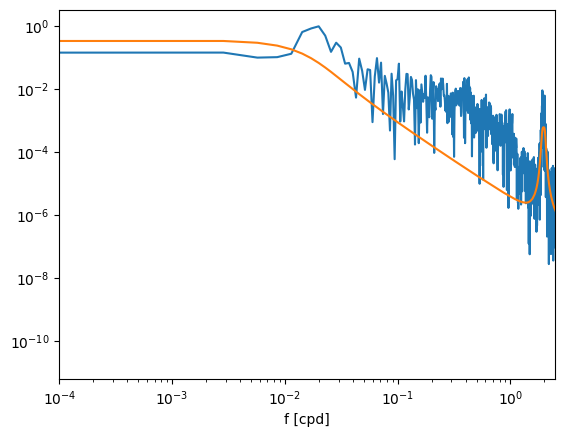

In [11]:
acf = covfunc(X, X[0], covparams, **cov_kwargs)
f, I = nsjax.periodogram(y.values, dt)
f_S, S = nsjax.bochner(acf, delta=dt)
plt.figure()
# plt.semilogy(f, I)
# plt.semilogy(f_S,S)
plt.loglog(f, I)
plt.loglog(f_S,S)
plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')

In [12]:
fidx = ((f > fmins[0]) & (f<fmaxs[0])) | ((f > fmins[1]) & (f<fmaxs[1]))
fidx

Array([False, False, False, ..., False, False, False], dtype=bool)

In [13]:
%%time
params, loss_val = nsjax.estimate_jax(y.values, X, covfunc, covparams, None, None,
                    fidx = fidx,
                      cov_kwargs=cov_kwargs,
                      maxiter=500,
                     opt= optax.adabelief(learning_rate=1e-1),
                     #opt= optax.sgd(learning_rate=3e-4),
                     verbose=True)
params

step 0, loss: -3788.31298828125
[1.10517025e-01 1.80967598e+01 1.35725701e+00 1.10517023e-02
 1.10517023e-02 4.52419043e+00 4.52419043e+00 1.35725701e+00
 1.35725701e+00]
step 25, loss: -6692.85888671875
[1.4966598e-01 1.1888836e+01 1.1549817e+00 1.5588557e-02 7.9175150e-03
 1.1042701e+01 7.4802728e+00 1.4800885e+00 1.1462147e+00]
step 50, loss: -6818.736328125
[0.18383104 9.098839   1.319809   0.02036359 0.01220175 7.1290994
 9.539362   1.7897278  1.6302223 ]
step 66, loss: -6832.27294921875
CPU times: user 1.39 s, sys: 99.3 ms, total: 1.49 s
Wall time: 2.12 s


Array([0.20083247, 7.9981885 , 1.3952557 , 0.01775778, 0.01242897,
       6.862022  , 7.8114    , 1.857063  , 1.721603  ], dtype=float32)

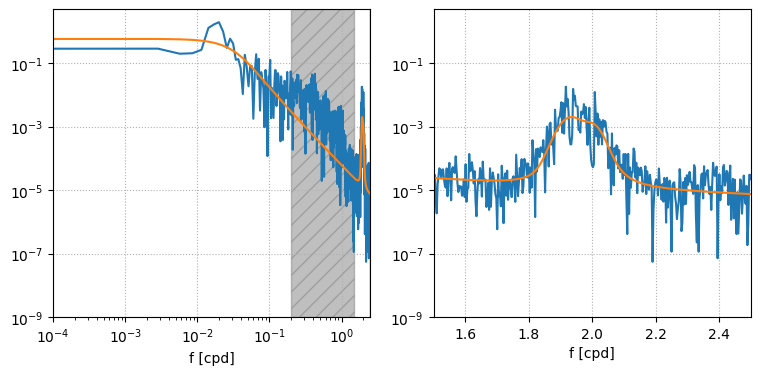

In [14]:
acf = covfunc(X, X[0], params, **cov_kwargs)
f_S, S = nsjax.bochner(acf, delta=dt)

acf = covfunc(X, X[0], covparams,**cov_kwargs)
f_S, Si = nsjax.bochner(acf, delta=dt)

plt.figure(figsize=(9,4))
ax=plt.subplot(121)
plt.loglog(f, 2*I)
plt.loglog(f_S,S)
# plt.loglog(f_S,Si,':')
plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')
plt.grid(True, ls=':')
plt.fill_between(f, 1e-9, 5, where=~fidx,
                color='0.5', alpha=0.5, hatch=r"//" )
ax.set_ylim(1e-9, 5)

ax=plt.subplot(122)
plt.semilogy(f, 2*I)
plt.semilogy(f_S,S)
# plt.semilogy(f_S,Si,':')

plt.xlim(1.5, fmax)
plt.xlabel('f [cpd]')
ax.set_ylim(1e-9, 5)
plt.grid(True, ls=':')

# Try dask

In [15]:
from dask.diagnostics import ProgressBar

In [16]:
# myds2=ds.isel(Nc=slice(1000,1010)).sel(time=slice(t1,t2))
# myds2

In [17]:
import jax.numpy as np

In [18]:
def compute_f_cpd_inv(lat):
    f_cor = 4*np.pi/86400*np.sin(np.abs(lat)*np.pi/180)
    return 2*np.pi/f_cor/86400

In [19]:
%%time
window=None
# inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=None, fmax=fmax)
inputs = dict(X=X, covfunc=covfunc, covparams_ic=covparams, fmin=None, fmax=None, fidx=fidx)

def estimate_spectral_params_jax(y, lat, X=X, 
                covfunc=covfunc, covparams_ic=covparams, fmin=fmin, fmax=fmax, fidx=fidx):
    #print(lat)
    
    #f_cor_cpd = compute_f_cpd_inv(lat)
    
    params, loss_val = nsjax.estimate_jax(y, X, covfunc, covparams, fmin, fmax,
                         fidx = fidx,
                         cov_kwargs=cov_kwargs,
                         maxiter=500,
                         opt= optax.adabelief(learning_rate=1e-1),
                         verbose=False)

    return params, np.array([loss_val])
    #return params, np.array([f_cor_cpd])
    #return np.concatenate([params, np.array([f_cor_cpd]) ])

print('\tBuilding the dask graph...')
params, loss_val = xr.apply_ufunc(estimate_spectral_params_jax,
                      myds[varname],
                      myds['yv'],
                      dask='parallelized',
                      kwargs=inputs,
                      output_dtypes=[y.dtype, y.dtype],
                      input_core_dims=(['time',],[]),
                      output_core_dims=(['params'],[]),
                      #output_sizes=,
                      dask_gufunc_kwargs={'output_sizes':{'params':len(covparams)}},
                      vectorize=True,
                     )

with ProgressBar():
    params = params.compute()
    #loss_val = loss_val.compute()
params

	Building the dask graph...
[########################################] | 100% Completed | 26.59 ss
CPU times: user 38.1 s, sys: 4.07 s, total: 42.2 s
Wall time: 26.6 s


<xarray.DataArray (Nc: 13, params: 9)>
array([[1.54443860e-01, 6.28691578e+00, 1.16922867e+00, 1.76762566e-02,
        4.94282227e-03, 4.89012146e+00, 3.90657711e+00, 1.27920890e+00,
        8.73048604e-01],
       [8.04130554e-01, 3.61928368e+00, 3.52534622e-01, 3.41968238e-02,
        3.21741775e-02, 1.95217204e+00, 1.90517163e+00, 6.48081183e-01,
        6.47654712e-01],
       [9.95663553e-02, 3.15049219e+00, 1.21462178e+00, 1.68396086e-02,
        1.05449092e-02, 4.58489323e+00, 3.84088397e+00, 1.68531120e+00,
        1.01715660e+00],
       [7.80648589e-02, 3.16250753e+00, 8.56184900e-01, 3.53371873e-02,
        2.04527266e-02, 5.73347282e+00, 1.20653801e+01, 1.99703264e+00,
        1.04289651e+00],
       [1.43960685e-01, 4.88447952e+00, 1.36474693e+00, 2.46993639e-02,
        1.17501291e-02, 1.07454624e+01, 4.43080044e+00, 1.27261329e+00,
        1.32194972e+00],
       [2.00832471e-01, 7.99818850e+00, 1.39525568e+00, 1.77577808e-02,
        1.24289747e-02, 6.86202192e+00, 7.81139994e+00, 1.85706306e+00,
        1.72160304e+00],
       [1.24577612e-01, 2.56982517e+00, 1.35293055e+00, 1.68303512e-02,
        8.49474780e-03, 6.31247377e+00, 8.52769947e+00, 1.42898178e+00,
        2.25460672e+00],
       [1.21440455e-01, 1.00294571e+01, 1.10161746e+00, 2.04773750e-02,
        8.47127847e-03, 5.27358580e+00, 5.48957300e+00, 1.76538908e+00,
        2.18336368e+00],
       [1.34697467e-01, 1.03891144e+01, 1.36595047e+00, 1.65930297e-02,
        5.73068857e-03, 6.89134312e+00, 6.27246094e+00, 1.62845874e+00,
        1.63837290e+00],
       [2.20840544e-01, 7.35215330e+00, 6.91074073e-01, 3.48934084e-02,
        2.12168898e-02, 3.04460192e+00, 2.36027670e+00, 6.57674074e-01,
        6.47962332e-01],
       [1.21653333e-01, 8.32167339e+00, 8.21233273e-01, 2.21586116e-02,
        2.24033054e-02, 4.77303600e+00, 4.66975498e+00, 2.14325809e+00,
        1.75931323e+00],
       [1.17947653e-01, 5.20257378e+00, 1.12643456e+00, 2.82936245e-02,
        1.73961464e-02, 8.05113316e+00, 6.11083508e+00, 1.11879885e+00,
        8.04460049e-01],
       [1.39451250e-01, 6.32270765e+00, 9.66673613e-01, 2.61086598e-02,
        1.84590258e-02, 3.48091817e+00, 3.04615617e+00, 1.27319360e+00,
        7.44534612e-01]])
Dimensions without coordinates: Nc, params

In [20]:
# Plot all the sites...

In [23]:
def plot_site(myds, params, ii):
    y = myds[varname].isel(Nc=ii)

    #y -= y.mean()
    
    X = (myds.time-myds.time[0]).values.astype(float)/1e9/86400
    X = tdays#[:,None]
    dt = X[1]-X[0]
    f, I = nsjax.periodogram(y.values, dt)
    acf = covfunc(X, X[0], params[ii,:].values, **cov_kwargs)
    f_S, S = nsjax.bochner(acf, delta=dt)
    
    plt.figure(figsize=(9,4))
    ax1=plt.subplot(121)
    plt.loglog(f, 2*I)
    plt.loglog(f_S,S)
    # plt.loglog(f_S,Si,':')
    plt.xlim(fmin, fmax)
    plt.xlabel('f [cpd]')
    plt.grid(True, ls=':')
    plt.ylim(1e-7,1e1)
    plt.fill_between(f, 1e-7, 10, where=~fidx,
                color='0.5', alpha=0.5, hatch=r"//" )
    
    ax2=plt.subplot(122)
    plt.semilogy(f, 2*I)
    plt.semilogy(f_S,S)
    # plt.semilogy(f_S,Si,':')
    
    plt.xlim(1.5, fmax)
    plt.xlabel('f [cpd]')
    ax1.set_title('lon: {:3.2f} E, lat: {:3.2f} N'.format(myds.xv[ii].values, myds.yv.values[ii]))
    plt.grid(True, ls=':')
    plt.ylim(1e-7,1e1)
    ax1.text(0.02,1.02, '(a)', transform=ax1.transAxes)
    ax2.text(0.02,1.02, '(b)', transform=ax2.transAxes)

    plt.tight_layout()

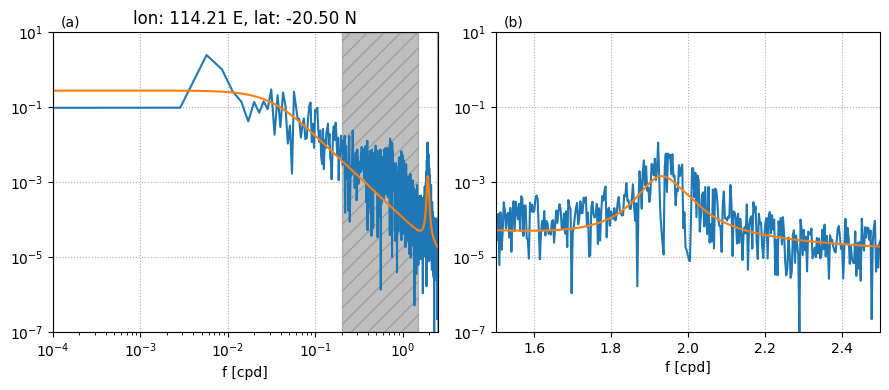

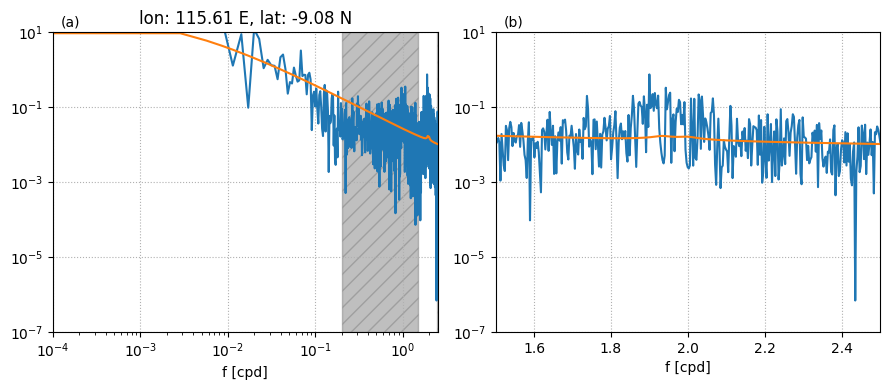

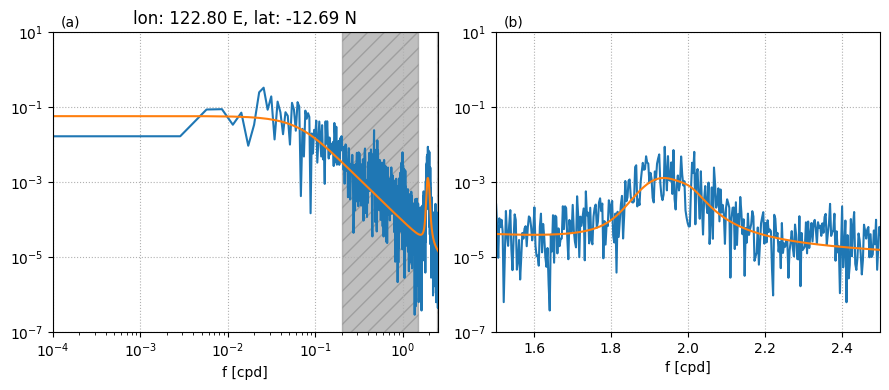

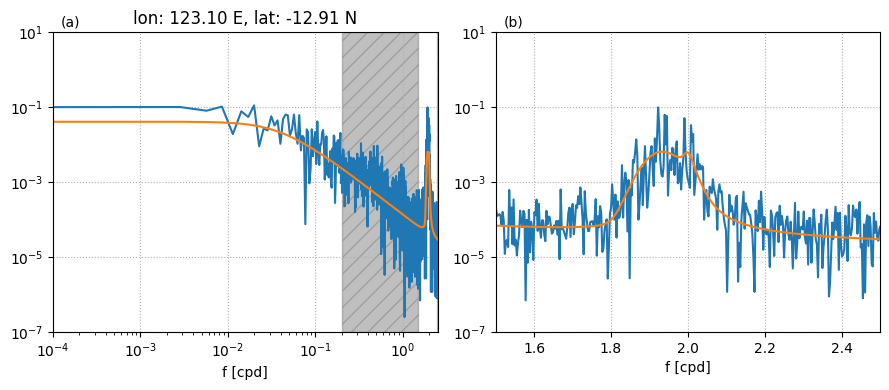

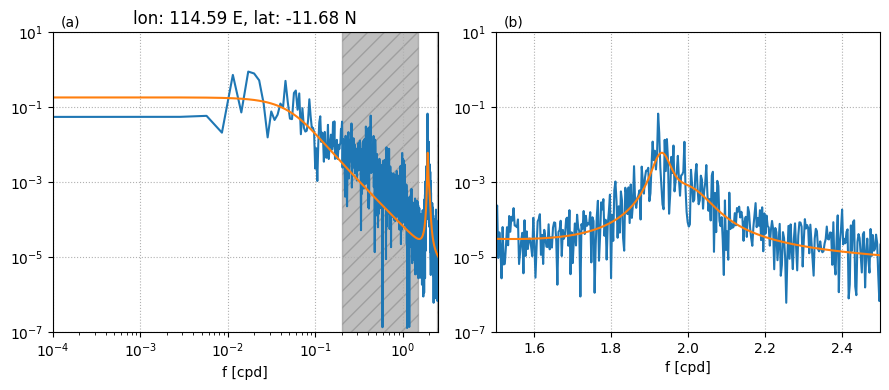

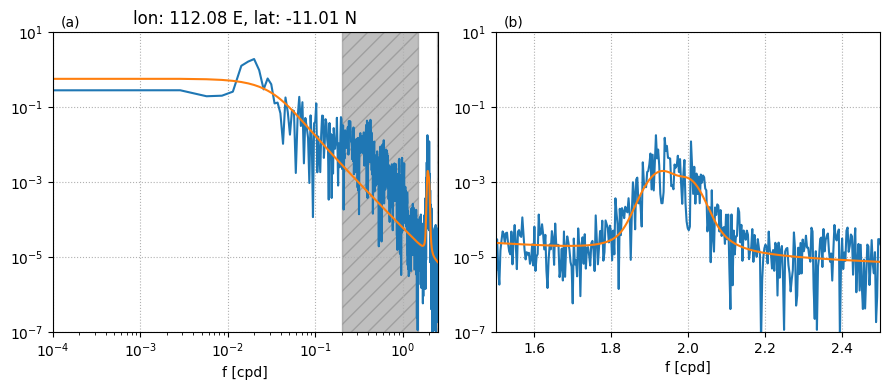

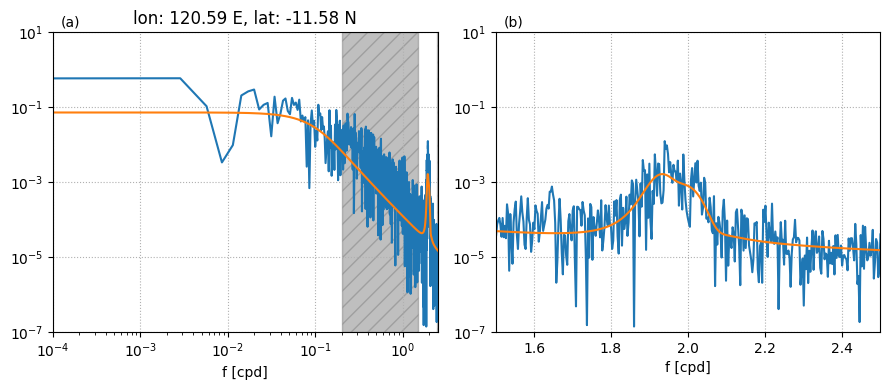

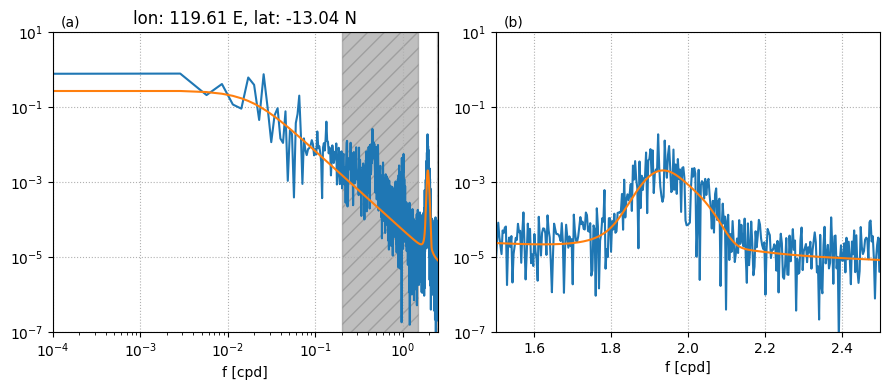

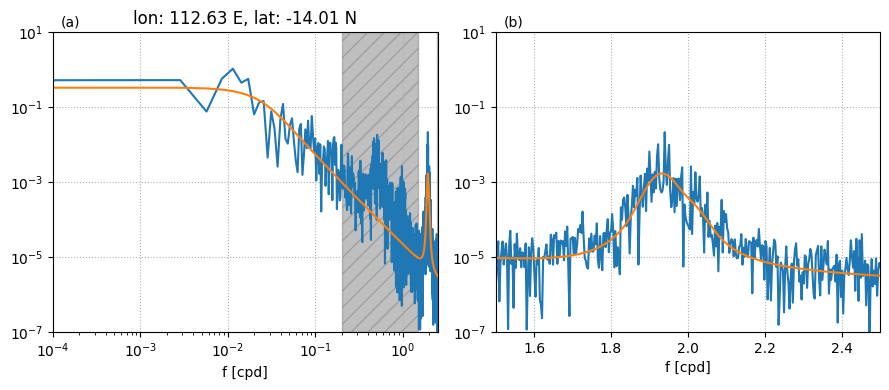

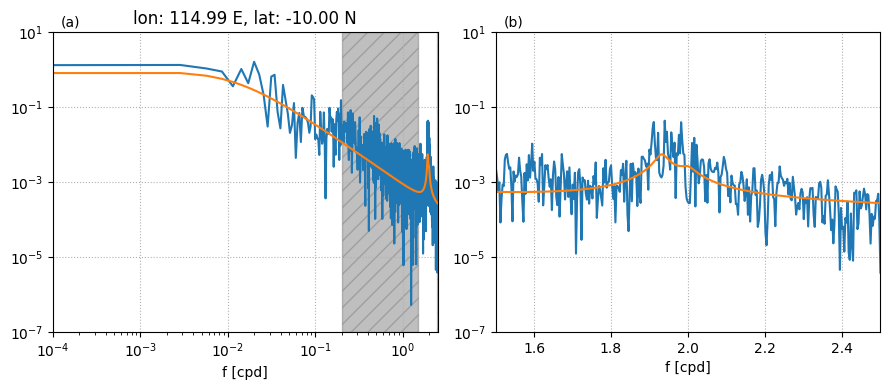

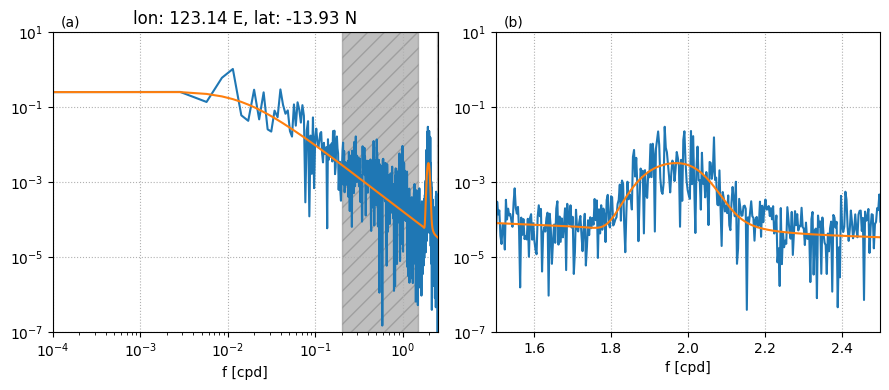

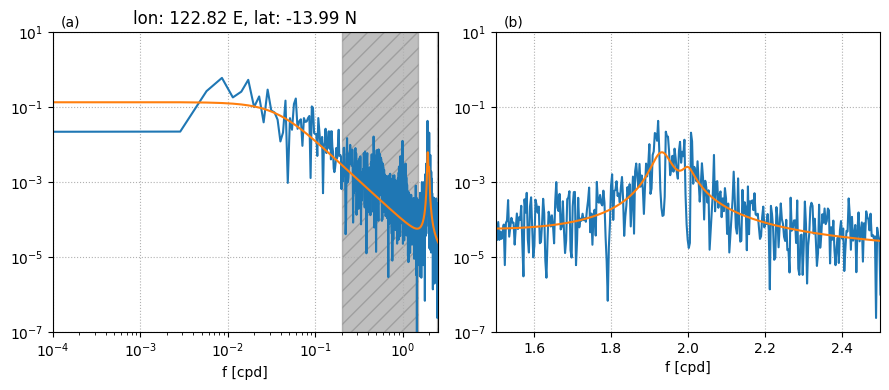

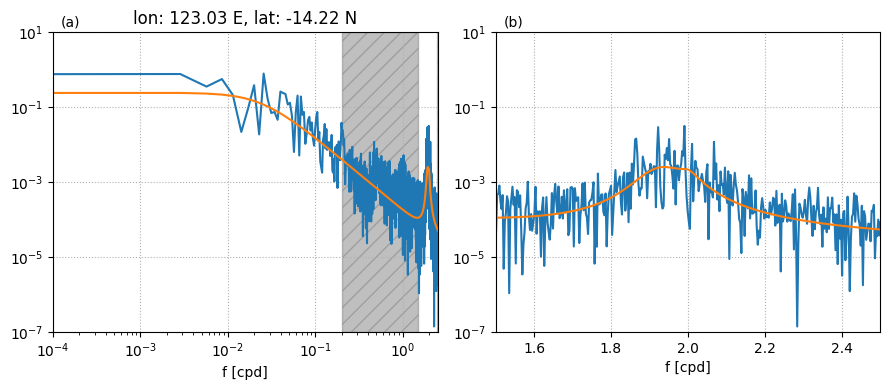

In [24]:
for ii in range(13):
    plot_site(myds, params, ii)
    #plt.savefig('../FIGURES/SUNTANS_PSD_v_eg_{:03d}.png'.format(ii), dpi=150)
    plt.savefig('../FIGURES/SUNTANS_PSD_M2S2_v_eg_{:03d}.png'.format(ii), dpi=150)

# Testing below here...

In [222]:
# This is hard-wired to the case above
def dwhittle_fast(x, y, ff, I, acffunc, params, delta = 1, h = None, fmin=0, fmax=np.inf):

    ff_boch, S_boch = bochner(acffunc(x, x[0], params), delta = delta, bias = True)

    # Subset frequencies
    #idx_boch = (ff_boch > fmin) & (ff_boch<fmax)
    idx = (ff > fmin) & (ff<fmax)

    # HACK: quick fix cause bochner isn't two sided yet
    whit = np.log(S_boch) + I/S_boch
    return -2* np.where(idx, whit, 0).sum()
    #return - 2 * np.sum(np.log(S_boch[idx]) + I[idx]/S_boch[idx])

@jax.value_and_grad
@partial(jax.jit, static_argnums=(5,6,7,8))
def loss(logparams,  X, y, f, I, covfunc,  dt, fmin, fmax):
    params = np.exp(logparams)
    return -dwhittle_fast(X, y, f, I, covfunc, params, delta=dt, fmin=fmin, fmax=fmax) 
    

In [223]:
dwhittle_fast(X, y.values, f, I, covfunc, covparams, fmin=fmin, fmax=fmax)

Array(94.04004, dtype=float32)

In [226]:
x=X
idx = (f > fmin) & (f<fmax)
def dwhittle_jax(params, acffunc):

    ff_boch, S_boch = bochner(acffunc(x, x[0], params))

    whit = np.log(S_boch) + I/S_boch
    return -2* np.where(idx, whit, 0).sum()

@jax.value_and_grad
@partial(jax.jit, static_argnums=(1))
def loss2(logparams, covfunc):
    params = np.exp(logparams)
    return -dwhittle_jax(params, covfunc) 

In [227]:
logparams = np.log(np.array(covparams))
# loss(logparams, np.array(X), np.array(y.values), f, I, covfunc,  dt, fmin, fmax)
loss2(logparams, covfunc)

(Array(-94.02051, dtype=float32),
 Array([-10123.3955,   6188.308 ,  -5100.722 ,   4073.4658,  -2464.0906],      dtype=float32))

In [229]:
%%time
opt = optax.sgd(learning_rate=3e-4)
# opt = optax.adam(learning_rate=1e-1)

opt_state = opt.init(logparams)
loss_val = np.inf
for i in range(500):
    #loss_val_new, grads = loss(logparams, np.array(X), np.array(y.values), f, I, covfunc,  dt, fmin, fmax)
    loss_val_new, grads = loss2(logparams, covfunc)
    updates, opt_state = opt.update(grads, opt_state)
    logparams = optax.apply_updates(logparams, updates)
    if i % 10 == 0:
        print(f'step {i}, loss: {loss_val_new}')
        print(np.exp(logparams))
    if np.abs(loss_val_new-loss_val) < 1e-2:
        print(f'step {i}, loss: {loss_val}')
        break

    loss_val = 1*loss_val_new


step 0, loss: -94.0205078125
[3.1264520e-01 1.5621961e+00 4.6191774e-03 2.9462857e+00 2.0943162e-06]
step 10, loss: -8574.44921875
[1.6673638e-02 1.0366410e+01 3.9194878e-03 1.9094799e+00 2.1366334e-06]
step 20, loss: -8687.0068359375
[1.4606985e-02 9.8059378e+00 3.3099456e-03 1.1555848e+00 2.2024378e-06]
step 30, loss: -8717.005859375
[1.3002753e-02 8.9476681e+00 3.2535247e-03 9.1621125e-01 2.2328136e-06]
step 40, loss: -8727.3828125
[1.1769324e-02 8.0455027e+00 3.2717658e-03 8.3886057e-01 2.2491135e-06]
step 50, loss: -8733.923828125
[1.0806603e-02 7.2658005e+00 3.2842890e-03 8.0960006e-01 2.2608058e-06]
step 60, loss: -8738.2978515625
[1.0082160e-02 6.6614285e+00 3.2905014e-03 7.9747480e-01 2.2707673e-06]
step 70, loss: -8740.84765625
[9.5710391e-03 6.2306075e+00 3.2931133e-03 7.9241145e-01 2.2799309e-06]
step 80, loss: -8742.107421875
[9.2338538e-03 5.9446020e+00 3.2938782e-03 7.9052067e-01 2.2886709e-06]
step 90, loss: -8742.646484375
[9.0235481e-03 5.7651720e+00 3.2938216e-03 7.9

Text(0.5, 0, 'f [cpd]')

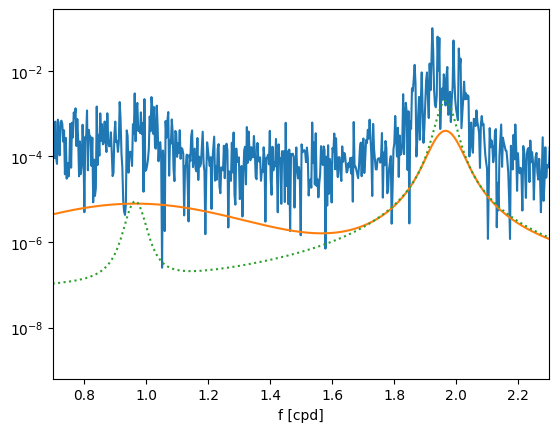

In [230]:
acf = covfunc(X, X[0], np.exp(logparams))
f_S, S = bochner(acf, delta=dt)

acf = covfunc(X, X[0], covparams)
f_S, Si = bochner(acf, delta=dt)

plt.figure()
plt.semilogy(f, 2*I)
plt.semilogy(f_S,S)
plt.semilogy(f_S,Si,':')

plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')

step 0, loss: 253890.65625
[1.0177167e+35 2.0136395e-22 8.2618419e+13 5.2516368e-13 9.8452469e+01]
step 10, loss: nan
[nan nan nan nan nan]
step 20, loss: nan
[nan nan nan nan nan]
step 30, loss: nan
[nan nan nan nan nan]
step 40, loss: nan
[nan nan nan nan nan]
step 50, loss: nan
[nan nan nan nan nan]
step 60, loss: nan
[nan nan nan nan nan]
step 70, loss: nan
[nan nan nan nan nan]
step 80, loss: nan
[nan nan nan nan nan]
step 90, loss: nan
[nan nan nan nan nan]
step 100, loss: nan
[nan nan nan nan nan]
step 110, loss: nan
[nan nan nan nan nan]
step 120, loss: nan
[nan nan nan nan nan]
step 130, loss: nan
[nan nan nan nan nan]
step 140, loss: nan
[nan nan nan nan nan]
step 150, loss: nan
[nan nan nan nan nan]
step 160, loss: nan
[nan nan nan nan nan]
step 170, loss: nan
[nan nan nan nan nan]
step 180, loss: nan
[nan nan nan nan nan]
step 190, loss: nan
[nan nan nan nan nan]
step 200, loss: nan
[nan nan nan nan nan]
step 210, loss: nan
[nan nan nan nan nan]
step 220, loss: nan
[nan nan

Array([nan, nan, nan, nan, nan], dtype=float32)

Text(0.5, 0, 'f [cpd]')

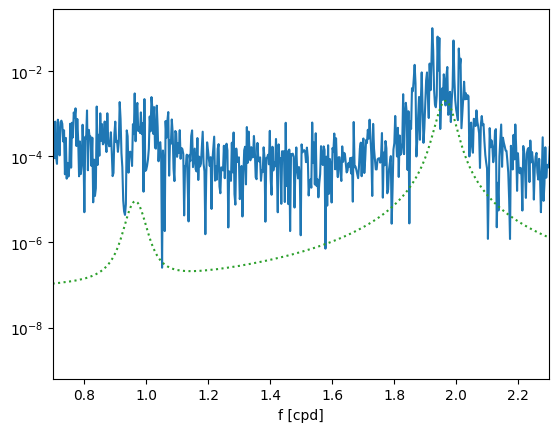

In [233]:
acf = covfunc(X, X[0], params)
f_S, S = bochner(acf, delta=dt)

acf = covfunc(X, X[0], covparams)
f_S, Si = bochner(acf, delta=dt)

plt.figure()
plt.semilogy(f, 2*I)
plt.semilogy(f_S,S)
plt.semilogy(f_S,Si,':')

plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')